# EVALUATION

In [27]:
from scipy.stats import norm, kstest
import pandas as pd
import numpy as np
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module('dependencies_for_data_generation')
N.load_module('dependencies_for_hmc_bnn')
N.load_module('dependencies_for_vi_bnn')
from dependencies_for_data_generation import *
from dependencies_for_hmc_bnn import *
from dependencies_for_vi_bnn import *

# Ignoring warnings for aesthetic reasons:
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from .\dependencies_for_data_generation.ipynb
importing Jupyter notebook from .\dependencies_for_hmc_bnn.ipynb
importing Jupyter notebook from .\dependencies_for_vi_bnn.ipynb


# Other Global Variables

In [32]:
cur_problem_id, samples, all_sample_predictions = 'A', None, {}

# Key Helper Functions

In [33]:
def load_data(problem_id):
    global cur_problem_id, samples, functional_model, vi_bnn, x_train, y_train, x_test, y_test
    
    cur_problem_id = problem_id
    samples = np.load(f'storage/hmc_samples--problem_{problem_id}.npy')
    functional_model.load_weights(problem_id)
    vi_bnn.load_weights(problem_id)
    
    df = pd.read_csv(f'storage/synthetic_training_data--problem_{problem_id}.csv')
    x_train, y_train = np.array(df['x_train']), np.array(df['y_train'])
    x_train, y_train = np.transpose(np.array([x_train])), np.transpose(np.array([y_train]))

    df = pd.read_csv(f'storage/synthetic_test_data--problem_{problem_id}.csv')
    x_test, y_test = np.array(df['x_test']), np.array(df['y_test'])
    x_test, y_test = np.transpose(np.array([x_test])), np.transpose(np.array([y_test]))

#================================================
def get_sample_predictions_for_hmc_bnn(layer=2):
    global cur_problem_id, samples, all_sample_predictions
    sample_predictions_train, sample_predictions_test = [], []
    for i in range(samples.shape[0]):
        sample_predictions_train.append(functional_model.predict_for_proposal(x_train, samples[i], layer).numpy().flatten())
        sample_predictions_test.append(functional_model.predict_for_proposal(x_test, samples[i], layer).numpy().flatten())

    all_sample_predictions[f'train--hmc--problem_{problem_id}'] = np.array(sample_predictions_train)
    all_sample_predictions[f'test--hmc--problem_{problem_id}'] = np.array(sample_predictions_test)
    return np.array(sample_predictions_train), np.array(sample_predictions_test)

#================================================
def get_sample_predictions_for_vi_bnn():
    global cur_problem_id, samples, all_sample_predictions
    sample_predictions_train, sample_predictions_test = [], []
    for i in range(samples.shape[0]):
        sample_predictions_train.append(vi_bnn.predict(x_train.astype('float32')).flatten())
        sample_predictions_test.append(vi_bnn.predict(x_test.astype('float32')).flatten())
        # Why do `.astype`? Check the implementation notes below.

    all_sample_predictions[f'train--vi--problem_{problem_id}'] = np.array(sample_predictions_train)
    all_sample_predictions[f'test--vi--problem_{problem_id}'] = np.array(sample_predictions_test)
    return np.array(sample_predictions_train), np.array(sample_predictions_test)

#================================================
def visually_validate_predictions(sample_predictions_train, sample_predictions_test):
    global x_train, y_train, x_test, y_test
    
    avg_sample_predictions_train = np.mean(sample_predictions_train, axis=0)
    avg_sample_predictions_test = np.mean(sample_predictions_test, axis=0)
    
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 4))
    axs[0, 0].scatter(x_train, avg_sample_predictions_train, s=5)
    axs[0, 1].scatter(x_test, avg_sample_predictions_test, s=5)
    axs[1, 0].scatter(x_train, y_train, s=5)
    axs[1, 1].scatter(x_test, y_test, s=5)
    
    axs[0, 0].set_title('TRAINING DATA\n\nAverage Predictions')
    axs[0, 1].set_title('TESTING DATA\n\nAverage Predictions')
    axs[1, 0].set_title('Generated')
    axs[1, 1].set_title('Generated')

    plt.suptitle('Visually Validating Predictions')

#================================================
def ks_test(x, sample_predictions, i, print_results=True):
    problem = pick_problem('A')
    mean = problem.f(x[i])
    sigma = 0.25
    dist = norm(mean, sigma)
    KS = kstest(sample_predictions[:, i], dist.cdf, alternative="two-sided", N=len(sample_predictions[:, i]))
    
    # Printing the results:
    if print_results:
        labels = ['statistic', 'pvalue']
        for l, ks in list(zip(labels, KS[:2])): print(f"{l} = {ks}")
    
    # Returning the results:
    return KS[:2]

#================================================
def ks_test_for_all_points(x, sample_predictions):
    ks_results = {'statistic':[], 'pvalue':[]}
    for i in range(len(x)):
        results = ks_test(x, sample_predictions, i, print_results=False)
        ks_results['statistic'].append(results[0]),  ks_results['pvalue'].append(results[1])
    return ks_results

**IMPLEMENTATION NOTE: Use of `.astype` in `get_sample_predictions_for_vi_bnn`**:

Before using `.astype('float32')`, I had gotten the following error:

```
File ~\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\linear.py:116, in Linear.forward(self, input)
    115 def forward(self, input: Tensor) -> Tensor:
--> 116     return F.linear(input, self.weight, self.bias)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float
```

The reason for this is that `x_train` and `x_test` were of the datatype 'float64' (i.e. 'double'), whereas the weights of the linear layers of the PyTorch-based neural network model are by default of datatype 'float32' (i.e. 'float'). Hence, `.astype('float32')` is applied to `x_train` and `x_test` to convert them to the same datatype as the weights of the linear layers, so that the matrix multiplication between inputs and weights can occur in the `forward` method of the model.

> **References**:
>
> - [_mat1 and mat2 must have the same dtype_ from **stackoverflow.com**](https://stackoverflow.com/questions/75102134/mat1-and-mat2-must-have-the-same-dtype))
> - [_Change the Data Type of the Given NumPy Array_ from **GeeksForGeeks.com**](https://www.geeksforgeeks.org/change-numpy-array-data-type/)

# Evaluation Function

In [34]:
def evaluate_problem(problem_id, bnn_type, visually_validate_predictions=False):
    get_sample_predictions = {'HMC BNN':get_sample_predictions_for_hmc_bnn, 'VI BNN': get_sample_predictions_for_vi_bnn}[bnn_type]
    
    load_data(problem_id)
    sample_predictions_train, sample_predictions_test = get_sample_predictions()
    if visually_validate_predictions:
        visually_validate_predictions(sample_predictions_train, sample_predictions_test)
    
    ks_results_train = ks_test_for_all_points(x_train, sample_predictions_train)
    ks_results_test = ks_test_for_all_points(x_train, sample_predictions_test)
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 2))
    axs[0].hist(ks_results_train['statistic'], bins=50)
    axs[1].hist(ks_results_test['statistic'], bins=50)
    axs[0].set_title('TRAINING DATA')
    axs[1].set_title('TEST DATA')
    plt.suptitle('KS-Statistic Distribution')
    plt.show()

    return ks_results_train, ks_results_test

# Performing Evaluation for HMC BNN

------------------------------------------------
PROBLEM A
------------------------------------------------


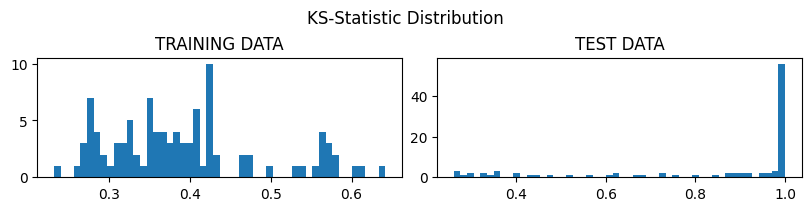

------------------------------------------------
PROBLEM B
------------------------------------------------


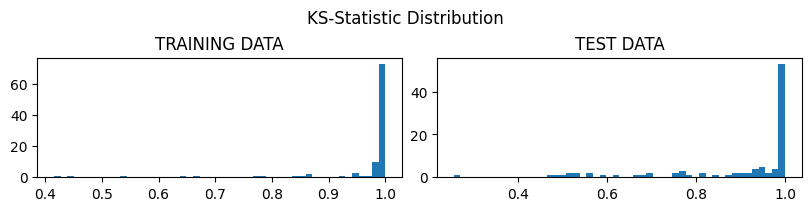

------------------------------------------------
PROBLEM C
------------------------------------------------


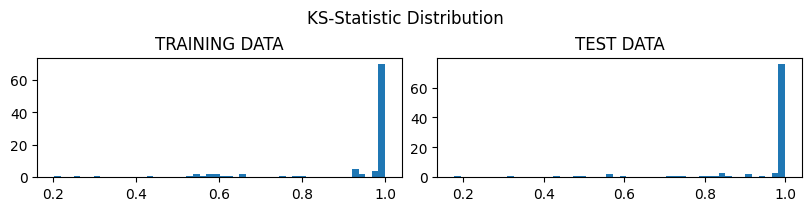

------------------------------------------------
PROBLEM D
------------------------------------------------


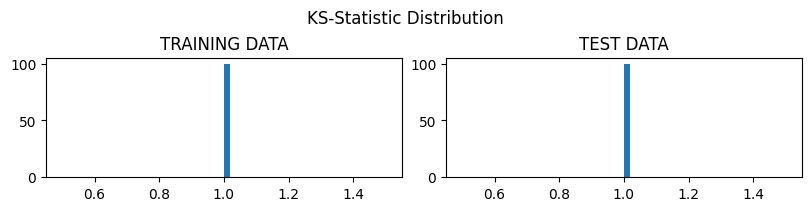

In [35]:
results_for_hmc_bnn = []
for problem_id in ['A', 'B', 'C', 'D']:
    print('-'*48 + f'\nPROBLEM {problem_id}\n' + '-'*48)
    results_for_hmc_bnn.append(evaluate_problem(problem_id, 'HMC BNN'))

# Performing Evaluation for VI BNN

------------------------------------------------
PROBLEM A
------------------------------------------------


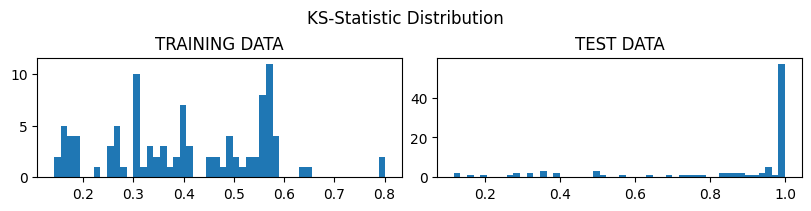

------------------------------------------------
PROBLEM B
------------------------------------------------


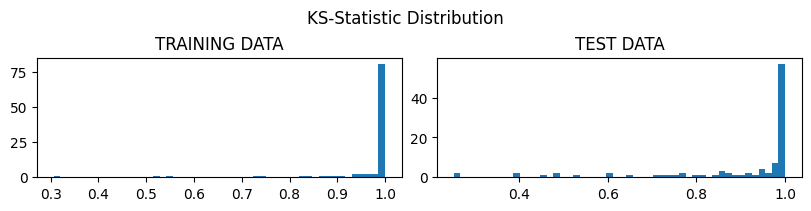

------------------------------------------------
PROBLEM C
------------------------------------------------


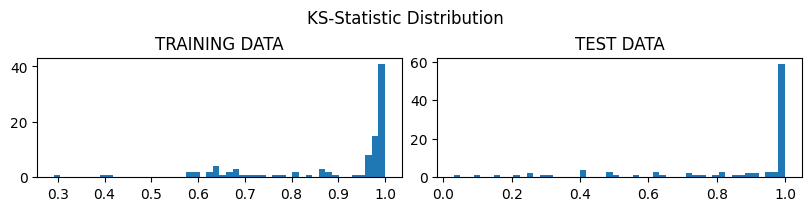

------------------------------------------------
PROBLEM D
------------------------------------------------


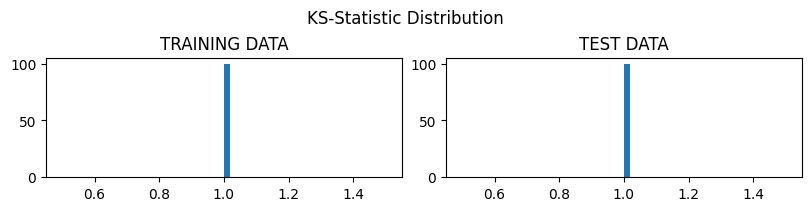

In [36]:
results_for_vi_bnn = []
for problem_id in ['A', 'B', 'C', 'D']:
    print('-'*48 + f'\nPROBLEM {problem_id}\n' + '-'*48)
    results_for_vi_bnn.append(evaluate_problem(problem_id, 'VI BNN'))